In [ ]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

KeyboardInterrupt: 

# 1. Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv, SAGEConv
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, LinkLoader, NodeLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import random
import networkx as nx
import tqdm
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import prince
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
csv_file = "node_information.csv"
node_information = pd.read_csv(csv_file, header=None)
node_information.rename(columns={0: "node_id"}, inplace=True)
node_information.head()

,node_id,1,2,3,4,5,6,7,8,9,...,923,924,925,926,927,928,929,930,931,932
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
node_information = pd.read_csv('node_information.csv', header=None, index_col=0)
train_set = pd.read_csv('train.txt', header=None, sep=' ')
train_set.columns = ['node1', 'node2', 'connected']
test_set = pd.read_csv('test.txt', header=None, sep=' ')
test_set.columns = ['node1', 'node2']

mapping = {node_information.index[i]: i for i in range(len(node_information))}
node_information.index = node_information.index.map(mapping)
train_set["node1"] = train_set["node1"].map(mapping)
train_set["node2"] = train_set["node2"].map(mapping)
test_set["node1"] = test_set["node1"].map(mapping)
test_set["node2"] = test_set["node2"].map(mapping)

In [4]:
node_information

,1,2,3,4,5,6,7,8,9,10,...,923,924,925,926,927,928,929,930,931,932
0,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_set

,node1,node2,connected
0,510,1991,1
1,1308,2872,1
2,100,1991,1
3,466,1221,1
4,723,2846,1
...,...,...,...
10491,44,3176,0
10492,1,3159,0
10493,1767,3272,1
10494,840,2385,0


In [6]:
# combien de samples positifs et négatifs
pos = len(train_set[train_set['connected'] == 1])
neg = len(train_set[train_set['connected'] == 0])
print(f"Positif: {pos}")
print(f"Negatif: {neg}")

Positif: 5248
Negatif: 5248


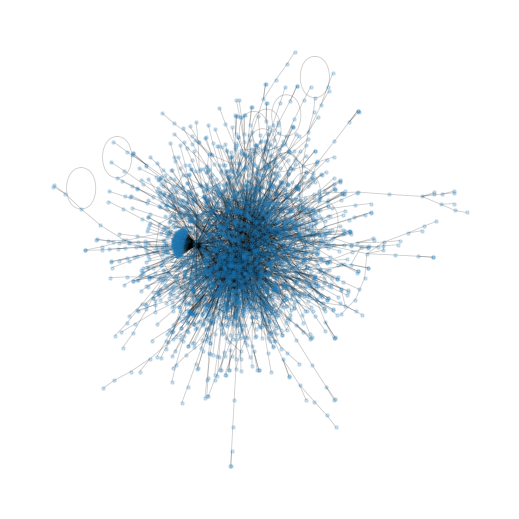

In [7]:
connected_edges = train_set[train_set['connected'] == 1]
training_graph = nx.from_pandas_edgelist(connected_edges, source='node1', target='node2', create_using=nx.Graph())
plt.figure(figsize=(5,5))

nx.draw(training_graph, node_size = 5, alpha = 0.2, width = 0.6)

plt.show()

In [232]:
# create test samples
test_samples = [tuple((element[0], element[1])) for element in test_set.values]
# create train and val samples
samples = list(zip(train_set['node1'], train_set['node2']))
labels = train_set['connected']
train_samples, val_samples, train_labels, val_labels = train_test_split(samples, labels, test_size=0.2, random_state=42)

# Afficher la taille des ensembles
print("Nombre d'échantillons d'entraînement :", len(train_samples))
print("Nombre d'échantillons de validation :", len(val_samples))

# Repartition des labels dans val et train
print("Nombre de labels positifs dans l'ensemble d'entraînement :", sum(train_labels))
print("Nombre de labels positifs dans l'ensemble de validation :", sum(val_labels))


Nombre d'échantillons d'entraînement : 8396
Nombre d'échantillons de validation : 2100
Nombre de labels positifs dans l'ensemble d'entraînement : 4207
Nombre de labels positifs dans l'ensemble de validation : 1041


In [233]:
def remove_val_edges(graph,val_samples):
    """
    Remove edges from validation set before computing
    """
    if nx.is_connected(graph) is not True:
        raise ValueError("The graph contains more than one connected component!")

    residual_g = graph.copy()

    # Shuffle the list of edges
    edges = list(residual_g.edges())

    for (source, target) in val_samples:
        if residual_g.has_edge(source, target):
            residual_g.remove_edge(source, target)

    return residual_g

residual_g = remove_val_edges(training_graph, val_samples)

In [234]:
residual_edges = list(residual_g.edges())
assert len(residual_edges) == sum(train_labels)

In [235]:
#nx.draw(residual_g, node_size = 5, alpha = 0.2, width = 0.6)

100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900


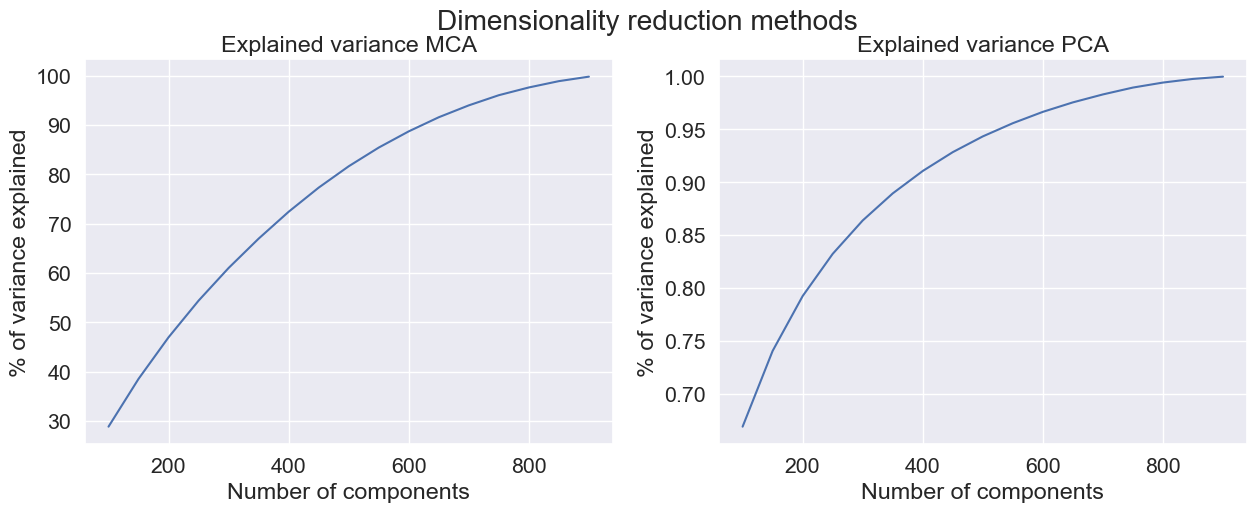

In [238]:
explained_variance_mca = []
explained_variance_pca = []
nb_comp = []
for i in range(100, node_information.shape[1], 50):
  print(i)
  mca = prince.MCA(n_components=i)
  mca.fit(node_information)
  explained_variance_mca.append(mca.eigenvalues_summary["% of variance"].sum())

  pca = PCA(n_components=i)
  pca.fit(node_information)
  explained_variance_pca.append(pca.explained_variance_ratio_.sum())
  nb_comp.append(i)

for i in range(len(explained_variance_mca)):
  explained_variance_mca[i] = np.array(explained_variance_mca[i].split("%")[:-1]).astype(float).sum()

fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(nb_comp, explained_variance_mca)
axs[0].set_title("Explained variance MCA")
axs[0].set_xlabel("Number of components")
axs[0].set_ylabel("% of variance explained")

axs[1].plot(nb_comp, explained_variance_pca)
axs[1].set_title("Explained variance PCA")
axs[1].set_xlabel("Number of components")
axs[1].set_ylabel("% of variance explained")

fig.suptitle("Dimensionality reduction methods")

plt.show()

In [236]:
def add_degree_centrality_to_features(residual_g, train_samples, val_samples,test_samples, node_information):
  deg_centrality = nx.degree_centrality(residual_g)
  node_information['degree_centrality'] = 0

  betweeness_centrality = nx.betweenness_centrality(residual_g)
  pagerank_centrality = nx.pagerank(residual_g)
  closeness_centrality = nx.closeness_centrality(residual_g)
  eigenvector_centrality = nx.eigenvector_centrality(residual_g)
  # katz_centrality = nx.katz_centrality(residual_g)
  triangles = nx.triangles(residual_g)
  print(closeness_centrality)
  print(eigenvector_centrality)
  print(triangles)


  every_samples = train_samples + val_samples + test_samples
  for edge in tqdm.tqdm(every_samples):
      source_node, target_node = edge[0], edge[1]
      # Degree Centrality
      node_information.at[source_node, 'degree_centrality'] = deg_centrality[source_node]
      # Attribution de la centralité degré au nœud cible
      node_information.at[target_node, 'degree_centrality'] = deg_centrality[target_node]

      # # Degree Centrality
      node_information.at[source_node, 'betweenness_centrality'] = betweeness_centrality[source_node]
      # # Attribution de la centralité degré au nœud cible
      node_information.at[target_node, 'betweenness_centrality'] = betweeness_centrality[target_node]

      # PageRank Centrality
      node_information.at[source_node, 'pagerank_centrality'] = pagerank_centrality[source_node]
      node_information.at[target_node, 'pagerank_centrality'] = pagerank_centrality[target_node]

      # Closeness Centrality
      node_information.at[source_node, 'closeness_centrality'] = closeness_centrality[source_node]
      node_information.at[target_node, 'closeness_centrality'] = closeness_centrality[target_node]

      # Eigenvector Centrality
      node_information.at[source_node, 'eigenvector_centrality'] = eigenvector_centrality[source_node]
      node_information.at[target_node, 'eigenvector_centrality'] = eigenvector_centrality[target_node]

      # # Katz Centrality
      # node_information.at[source_node, 'katz_centrality'] = katz_centrality[source_node]
      # node_information.at[target_node, 'katz_centrality'] = katz_centrality[target_node]

      # Triangles
      node_information.at[source_node, 'triangles'] = triangles[source_node]
      node_information.at[target_node, 'triangles'] = triangles[target_node]

  return node_information


In [237]:
def add_kcore_number_to_features(residual_g, train_samples, val_samples,test_samples, node_information):
  residual_g_copy = residual_g.copy()
  residual_g_copy.remove_edges_from(nx.selfloop_edges(residual_g_copy))
  kcore = nx.core_number(residual_g_copy)
  node_information['kcore'] = 0
  every_samples = train_samples + val_samples + test_samples
  for edge in tqdm.tqdm(every_samples):
      source_node, target_node = edge[0], edge[1]
      # kcore
      node_information.at[source_node, 'kcore'] = kcore[source_node]

      # Attribution kcore number au nœud cible
      node_information.at[target_node, 'kcore'] = kcore[target_node]
  return node_information

In [208]:
node_information = add_degree_centrality_to_features(residual_g,train_samples, val_samples,test_samples, node_information)
node_information = add_kcore_number_to_features(residual_g,train_samples, val_samples,test_samples, node_information)

{510: 0.0, 1991: 0.2250598952395173, 1308: 0.15341908801218382, 2872: 0.13280410949711474, 100: 0.17812028768801821, 466: 0.18878314750524539, 1221: 0.16626461959654795, 723: 0.14296522595032024, 2846: 0.1440363345303354, 782: 0.11994596135974274, 2553: 0.13962721712406465, 599: 0.12755643150843435, 3231: 0.13078969521780454, 2228: 0.0005561735261401557, 3173: 0.0003707823507601038, 1272: 0.1572201788164595, 1639: 0.17391883079153744, 900: 0.1478349687800247, 2875: 0.15017883994341588, 2428: 0.15010935291510197, 3449: 0.182311794879328, 292: 0.1860628512367993, 337: 0.18058660672850776, 2243: 0.0, 2688: 0.1060988762939299, 764: 0.15693498076563753, 1833: 0.13248548810117985, 38: 0.06945118308541914, 2390: 0.0, 676: 0.15164421337435663, 2764: 0.12166654377939777, 3421: 0.00027808676307007786, 2263: 0.14194873725126414, 2733: 0.1669598399422395, 3481: 0.20348025965520292, 2682: 0.12709420262974944, 3533: 0.1491432428400249, 2353: 0.142337979154443, 3350: 0.12191801540314326, 480: 0.19111

  0%|          | 0/13994 [00:00<?, ?it/s]C:\Users\Guillaume\AppData\Local\Temp\ipykernel_25128\1211442952.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.004727474972191324' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  node_information.at[source_node, 'degree_centrality'] = deg_centrality[source_node]
100%|██████████| 13994/13994 [00:00<00:00, 17056.88it/s]


In [209]:
# Change last colum into float
node_information.iloc[:, 1:] = node_information.iloc[:, 1:].astype(float)
# Check types
node_information.dtypes

C:\Users\Guillaume\AppData\Local\Temp\ipykernel_25128\235239713.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0
0       1.0
1       0.0
2       1.0
3       1.0
4       1.0
       ... 
3592    2.0
3593    1.0
3594    1.0
3595    1.0
3596    1.0
Name: kcore, Length: 3597, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  node_information.iloc[:, 1:] = node_information.iloc[:, 1:].astype(float)


1                         float64
2                         float64
3                         float64
4                         float64
5                         float64
                           ...   
pagerank_centrality       float64
closeness_centrality      float64
eigenvector_centrality    float64
triangles                 float64
kcore                     float64
Length: 939, dtype: object

In [261]:
def feature_extractor(graph, samples, node_information):
    """
    Creates a feature vector for each edge of the graph contained in samples
    """
    deg_centrality = nx.degree_centrality(graph)

    feature_edge_vector = []
    feature_vector = []
    for edge in tqdm.tqdm(samples):
        source_node, target_node = edge[0], edge[1]


        # Preferential Attachement
        if source_node not in graph or target_node not in graph:
            pref_attach = 0
        else:
            pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        if source_node not in graph or target_node not in graph:
            aai = 0
        else:
            aai = sum(1 / np.log(graph.degree(z)) for z in nx.common_neighbors(graph, source_node, target_node) if np.log(graph.degree(z)) != 0)
            #check if aai is not nan

        # Compute the Jaccard coefficient
        if source_node not in graph or target_node not in graph:
            jacard_coeff = 0
        else:
            neighbords_source, neighbord_target = set(graph.neighbors(source_node)), set(graph.neighbors(target_node))
            inter = len(neighbords_source.intersection(neighbord_target))
            union = len(neighbords_source.union(neighbord_target))
            if union == 0:
                jacard_coeff = 0
            else:
                jacard_coeff = inter/union
        
        # # Cosine similarity
        if source_node not in graph or target_node not in graph:
            cosine_sim = 0
        else:
            neighbords_source, neighbord_target = set(graph.neighbors(source_node)), set(graph.neighbors(target_node))
            inter = len(neighbords_source.intersection(neighbord_target))
            if (np.sqrt(len(neighbords_source) * len(neighbord_target))) != 0:
              cosine_sim = inter / (np.sqrt(len(neighbords_source) * len(neighbord_target)))
            else:

              cosine_sim = 0
        # Shortest path
        # if source_node not in graph or target_node not in graph:
        #     shortest_path = 0
        # else:
        #     try:
        #         shortest_path = nx.shortest_path_length(graph, source_node, target_node)
        #         if np.isinf(shortest_path):
        #           print('inf short')
        #           shortest_path = 0
        #     except:
        #         shortest_path = -1


        feature_edge_metrics = np.array([pref_attach, aai, jacard_coeff])

        feature_edge_vector.append(feature_edge_metrics)

        source_node_information = list(node_information.loc[int(source_node)][:])
        target_node_information = list(node_information.loc[int(target_node)][:])
        # Create edge feature vector with all metric computed above
        feature_vector.append(np.concatenate([source_node_information, target_node_information,feature_edge_metrics]) ) 
    return np.array(feature_vector)

In [262]:
# --- Create feature vector for all edges in training set and val set ---
train_features = feature_extractor(residual_g, train_samples, node_information)
val_features = feature_extractor(residual_g, val_samples, node_information)
test_features = feature_extractor(training_graph, test_samples, node_information)

  0%|          | 0/8396 [00:00<?, ?it/s]

100%|██████████| 3498/3498 [00:06<00:00, 578.07it/s]


In [263]:
# model = LogisticRegression()
# Model SVC
# model = SVC(kernel='linear')
# Model Random Forest
model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

In [272]:
def prediction( model , train_features, train_labels, val_features, val_labels = None):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    model.fit(train_features, train_labels)
    train_preds = model.predict(train_features)
    val_preds =  model.predict(val_features)#

    if val_labels is not None:
        print("Accuracy: ", accuracy_score(val_labels, val_preds))
        print("Precision: ", precision_score(val_labels, val_preds))
        print("Recall: ", recall_score(val_labels, val_preds))
        print("F1: ", f1_score(val_labels, val_preds))
        print("Confusion matrix: ", confusion_matrix(val_labels, val_preds))
        # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
        fpr, tpr, _ = roc_curve(val_labels, val_preds)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")
        plt.show()
    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    fpr, tpr, _ = roc_curve(train_labels, train_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1])
    plt.show()
    if hasattr(model, 'feature_importances_'):
        top_n_features = 10
        # Check if the model has attribute 'feature_importances_'
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
        selected_features = indices[:top_n_features]  # Select top N features
        print("Selected top", top_n_features, "important features:", selected_features)
        
        # Select only the top features for training and validation
        train_features_selected = train_features[:, selected_features]
        val_features_selected = val_features[:, selected_features]
        
        # Retrain the model with selected features
        model.fit(train_features_selected, train_labels)
        train_preds = model.predict(train_features_selected)
        val_preds = model.predict(val_features_selected)

    if val_labels is not None:
        print("Accuracy: ", accuracy_score(val_labels, val_preds))
        print("Precision: ", precision_score(val_labels, val_preds))
        print("Recall: ", recall_score(val_labels, val_preds))
        print("F1: ", f1_score(val_labels, val_preds))
        print("Confusion matrix: ", confusion_matrix(val_labels, val_preds))
        # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
        fpr, tpr, _ = roc_curve(val_labels, val_preds)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")
        plt.show()
        # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    fpr, tpr, _ = roc_curve(train_labels, train_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1])
    plt.show()
    
    return train_preds, val_preds

Accuracy:  0.6666666666666666
Precision:  0.7264276228419655
Recall:  0.5254562920268973
F1:  0.6098104793756968
Confusion matrix:  [[853 206]
 [494 547]]


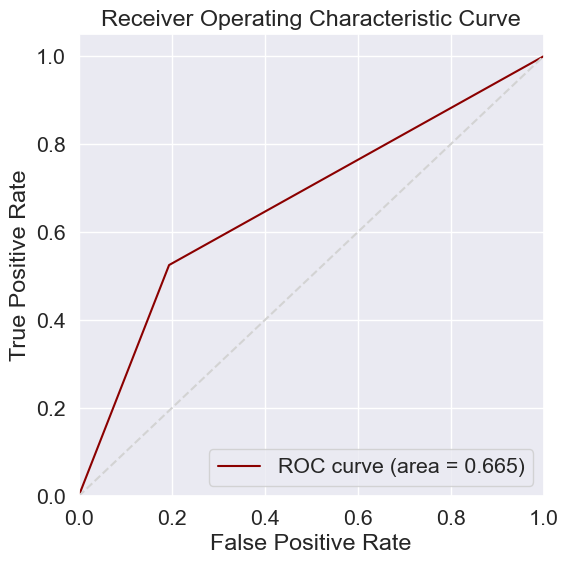

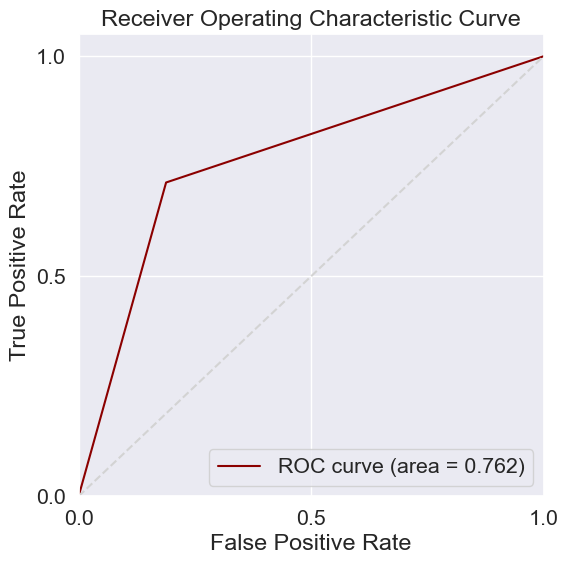

Selected top 10 important features: [1864 1207 1200 1190 1866 1059 1209 1865 1470 1126]
Accuracy:  0.6661904761904762
Precision:  0.72911051212938
Recall:  0.5196926032660903
F1:  0.606842400448682
Confusion matrix:  [[858 201]
 [500 541]]


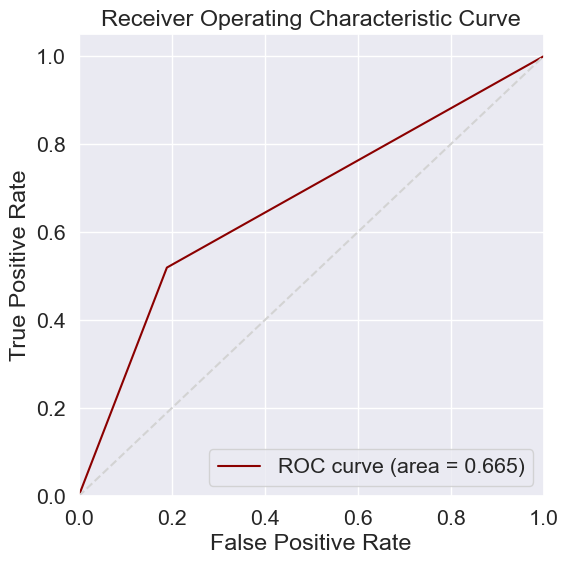

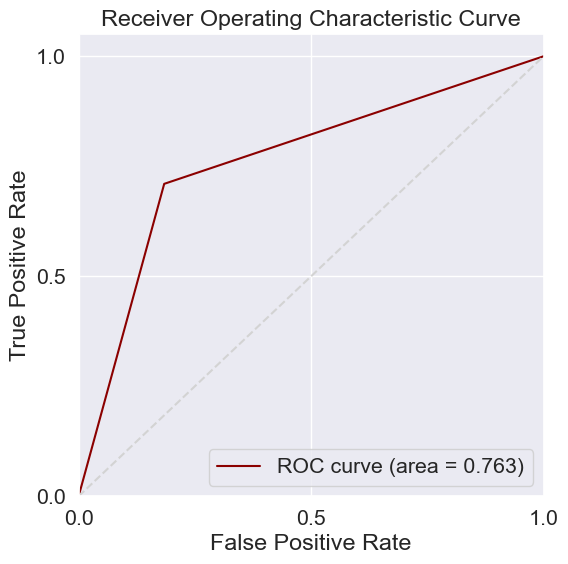

In [273]:
train_preds, val_preds = prediction( model , train_features, train_labels, val_features, val_labels)

In [266]:
#Compute metrics for training set
def compute_metrics(labels,preds):
    
    accuracy = accuracy_score(labels,preds)
    precision = precision_score(labels,preds)
    recall = recall_score(labels,preds)
    f1 = f1_score(labels,preds)
    roc_auc = roc_auc_score(labels,preds)
    # Confusion matrix
    conf_matrix = confusion_matrix(labels,preds)

    # Display the metrics
    print("Training Set Metrics:")
    print("Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}, ROC AUC: {:.3f}".format(
        accuracy, precision, recall, f1, roc_auc))
        
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()



Training Set Metrics:
Accuracy: 0.762, Precision: 0.792, Recall: 0.713, F1 Score: 0.750, ROC AUC: 0.762


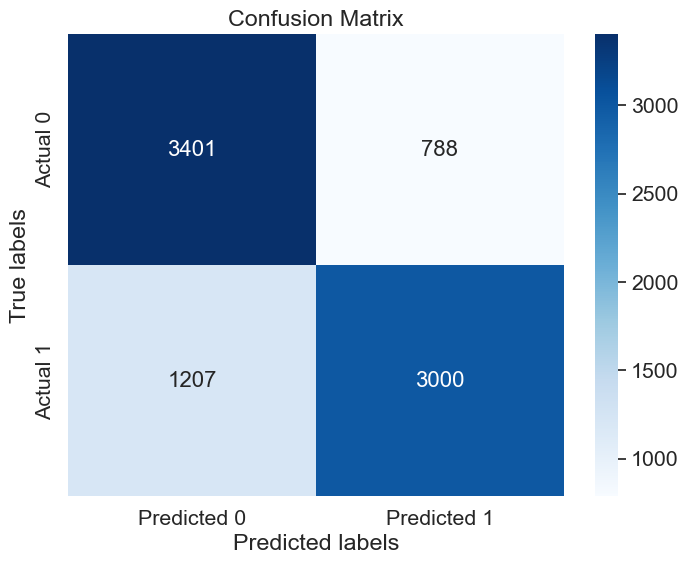

Training Set Metrics:
Accuracy: 0.667, Precision: 0.726, Recall: 0.525, F1 Score: 0.610, ROC AUC: 0.665


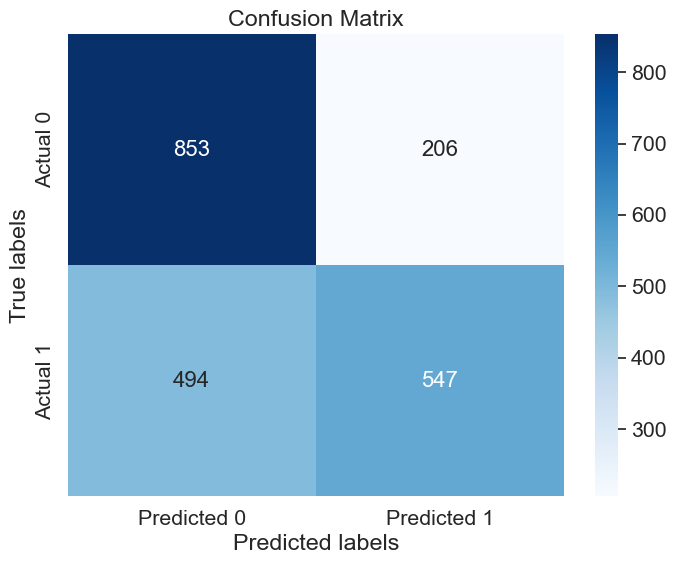

In [267]:
compute_metrics(train_labels,train_preds)
compute_metrics(val_labels,val_preds)

100%|██████████| 3498/3498 [00:05<00:00, 604.95it/s]


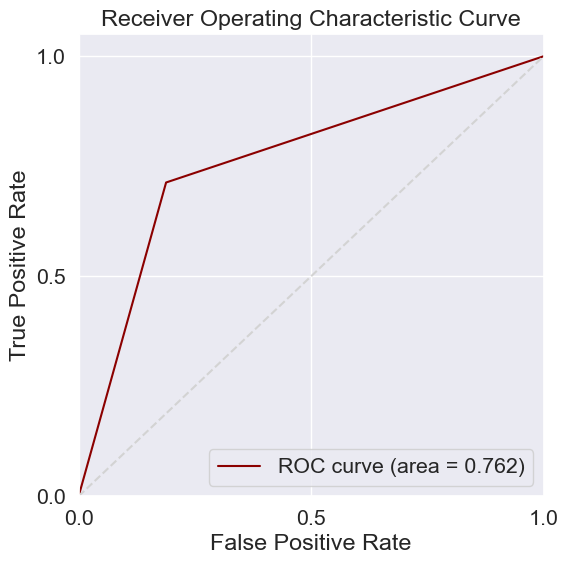

In [268]:
test_features = feature_extractor(training_graph, test_samples, node_information)
# --- Link prediction ---
train_preds, test_preds = prediction(model,train_features,train_labels, test_features)

In [269]:
test_preds

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [270]:
logistic_pred = zip(np.array(range(len(test_set))), test_preds)

In [271]:
with open("ggg_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in logistic_pred:
         csv_out.writerow(row)
    pred.close()